# Uplift Modeling Part 2: Modeling Strategies

1. Strategies to model incremental lift and implement using Python packages. 
2. Estimate purchase uplift for Megafon telecom


# SECTION 1: S Learner model

The fundamental problem  uplift modeling tries to solve is this: If a given customer may _ONLY either receive or not receive an intervention_, they CANNOT do both. 

That is, in a marketing campaign, they can either be in the treatment group or the control group, they cannot be in both. This means that the uplift of an individual customer cannot be measured directly, it can only be estimated based on groups of similar customers. 

We have seen how to do uplift modeling in the part 1 course. Let's build on those concepts and start modeling using multiple approaches starting with the S-Learner.

In [6]:
# !pip install lightgbm

## 1. Building the S-Learner Model from scratch

__Load packages__

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns

# Machine learning model
from lightgbm import LGBMRegressor

__Import Dataset__

Megafon is the second largest Mobile phone operator. The company serves 62.1 million subscribers in Russia and 1.6 million in Tajikistan. It is headquartered in Moscow.

Source: MegaFon Uplift Competition hosted in may 2021.

More details about the contents of the columns can be found [here](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_megafon.html).

In [154]:
# pip install scikit-uplift
from sklift.datasets import fetch_megafon
dataset = fetch_megafon()

In [155]:
data, target, treatment = dataset.data, dataset.target, dataset.treatment

Number of rows and columns.

In [156]:
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858


In [157]:
# nrows, ncols
data.shape

(600000, 50)

Assign treatment and target

In [158]:
data['treatment_type'] = treatment
data['target'] = target
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_type,target
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,control,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,control,0
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,treatment,0
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,treatment,0
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,treatment,0


In [159]:
print(data.columns.values.tolist())

['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18', 'X_19', 'X_20', 'X_21', 'X_22', 'X_23', 'X_24', 'X_25', 'X_26', 'X_27', 'X_28', 'X_29', 'X_30', 'X_31', 'X_32', 'X_33', 'X_34', 'X_35', 'X_36', 'X_37', 'X_38', 'X_39', 'X_40', 'X_41', 'X_42', 'X_43', 'X_44', 'X_45', 'X_46', 'X_47', 'X_48', 'X_49', 'X_50', 'treatment_type', 'target']


Features and Dependent variable

For the S-Learner, we keep the treatment as a feature so the model learns how the Y will behave with and without treatment.

In [160]:
# Features
features = data.drop(['target'], axis=1)
features['treatment_type'] = features['treatment_type'].map({"treatment":1, "control":0})

# Treatment Type
treatment = data['treatment_type']

# Dependent variable
y = data.loc[:, ['target']]

__Init the model__

__Train the LightGBM model__

In [161]:
# Initiate the light GBM model
s_learner = LGBMRegressor()

# Fit the model
s_learner.fit(features, y);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12752
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 51
[LightGBM] [Info] Start training from score 0.204190


## 2. How to Make Predictions

Now the model has been trained by seeing both Treatment and control datasets. 

Let's try to predict how the control would have 'behaved' if they were treated and viceversa.

In [162]:
# Set treatment value to 1
features_with_treatment = features.assign(treatment_type = 1)

# With treatment predictions
pred_with_treatment = s_learner.predict(features_with_treatment)

# Set treatment value to 0
features_without_treatment = features.assign(treatment_type = 0)

# With treatment predictions
pred_without_treatment = s_learner.predict(features_without_treatment)

## 3. Compute Uplift - ITE and ATE

The individual treatment effect (ITE) is nothing but the difference between the predicted outcome with and without treatment. 

In [181]:
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_type,target
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,control,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,control,0
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,treatment,0
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,treatment,0
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,treatment,0


In [190]:
# ITE
ite = pred_with_treatment - pred_without_treatment

# Save ITE data in a pandas dataframe
ite_df = pd.DataFrame({'ITE': ite, 
                       'y': data['target'],
                       'treatment': data['treatment_type'].map({"control":0,"treatment":1}),
                       'with_treatment_pred':pred_with_treatment, 
                       'without_treatment_pred': pred_without_treatment})

# Take a look at the data
ite_df.head()

,ITE,y,treatment,with_treatment_pred,without_treatment_pred
0,-0.105267,0,0,0.033794,0.139061
1,0.114123,0,0,0.249895,0.135772
2,0.064317,0,1,0.267660,0.203343
3,0.096103,0,1,0.232924,0.136820
4,0.119106,0,1,0.223457,0.104350


__Plot histogram__

array([[<Axes: title={'center': 'ITE'}>]], dtype=object)

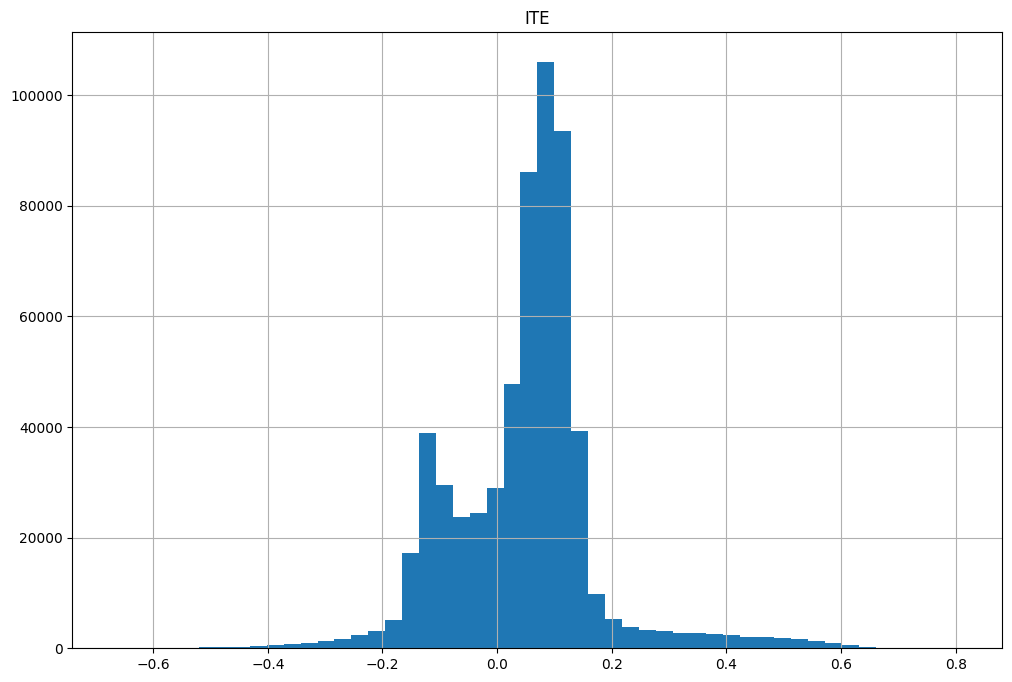

In [191]:
# visualization
ite_df.hist(column ='ITE', bins=50, grid=True, figsize=(12, 8))

In [192]:
# Calculate ATE
ATE = ite_df['ITE'].mean()

# Print out results
print(f'The average treatment effect (ATE) is {ATE:.2f}')

The average treatment effect (ATE) is 0.05


There appears to be an average treatment effect of positive 0.05.

## 4. Customer Segmentation

1. Persuadables are those who buy with treatment and do not buy without treatment.

2. Lost Causes are those who do not buy with or without treatment.


3. Sure Things are those who buy with or without treatment.


4. Sleeping Dogs are those who buy without treatment and do not buy with treatment.

In [193]:
def segment(df_scores=None,cutoff=0.5):
    df_scores['type'] = ""
    # Persuadables:  P(R|T) > 0.5 AND P(R|C) < 0.5  (aka P(R|T) > P(R|C))
    df_scores.loc[(df_scores.with_treatment_pred >= cutoff) & (df_scores.without_treatment_pred < cutoff), 'type'] = "persuadable"        
    # Sleeping Dogs: P(R|T) < 0.5 AND P(R|C) > 0.5  (aka P(R|T) < P(R|C))
    df_scores.loc[(df_scores.with_treatment_pred < cutoff) & (df_scores.without_treatment_pred >= cutoff), 'type'] = "sleeping_dog"
    # Lost Causes: P(R|T) < 0.5 & P(R|C) < 0.5
    df_scores.loc[(df_scores.with_treatment_pred < cutoff) & (df_scores.without_treatment_pred < cutoff), 'type'] = "lost_cause"
    # Sure things: P(R|T) > 0.5 & P(R|C) > 0.5
    df_scores.loc[(df_scores.with_treatment_pred >= cutoff) & (df_scores.without_treatment_pred > cutoff), 'type'] = "sure_thing"
    # Check 
    print("Freq Count:\n", df_scores['type'].value_counts())
    return(df_scores)

__Segment with cutoff=0.5__

In [194]:
ite_df = segment(ite_df)
ite_df.sample(10, random_state=11)

Freq Count:
 lost_cause      552638
sure_thing       21165
persuadable      19127
sleeping_dog      7070
Name: type, dtype: int64


,ITE,y,treatment,with_treatment_pred,without_treatment_pred,type
302955,0.009944,1,1,0.185195,0.175251,lost_cause
146084,-0.084764,0,1,0.023818,0.108582,lost_cause
306293,0.420268,0,0,0.532262,0.111994,persuadable
116178,-0.090687,0,0,0.105121,0.195808,lost_cause
376149,0.089212,0,0,0.215918,0.126706,lost_cause
513307,0.055182,0,1,0.185181,0.129999,lost_cause
256709,0.628278,0,1,0.796661,0.168383,persuadable
546196,0.101651,0,1,0.199973,0.098322,lost_cause
449133,0.075018,0,1,0.221871,0.146853,lost_cause
527054,0.253070,0,0,0.365707,0.112637,lost_cause


__Segment with cutoff=0.4__

In [195]:
ite_df = segment(ite_df, cutoff=0.4)
ite_df.sample(10, random_state=10)

Freq Count:
 lost_cause      531886
sure_thing       31141
persuadable      30871
sleeping_dog      6102
Name: type, dtype: int64


,ITE,y,treatment,with_treatment_pred,without_treatment_pred,type
71213,0.488510,0,0,0.605183,0.116673,persuadable
381916,0.149764,0,0,0.358011,0.208247,lost_cause
423558,-0.137778,0,1,0.036265,0.174043,lost_cause
62340,0.106149,0,0,0.219689,0.113540,lost_cause
466131,0.111528,0,0,0.220393,0.108866,lost_cause
329993,0.433178,0,1,0.580644,0.147465,persuadable
218585,0.182318,0,0,0.330468,0.148150,lost_cause
421985,0.123184,0,0,0.215145,0.091960,lost_cause
215626,-0.035653,0,1,0.103169,0.138821,lost_cause
505824,0.057195,0,0,0.169489,0.112294,lost_cause


__View Top Uplifts__

In [196]:
ite_df.sort_values('ITE', ascending=False).head(10)

,ITE,y,treatment,with_treatment_pred,without_treatment_pred,type
29734,0.807585,0,0,0.950233,0.142648,persuadable
179044,0.794509,0,0,0.926383,0.131874,persuadable
46961,0.792147,1,1,0.911921,0.119773,persuadable
17578,0.790525,1,1,0.948787,0.158262,persuadable
305288,0.780431,0,0,0.951108,0.170677,persuadable
597782,0.776930,0,0,0.907816,0.130886,persuadable
543191,0.771086,1,1,0.911659,0.140573,persuadable
420219,0.756989,0,0,0.881642,0.124653,persuadable
363199,0.753737,1,1,0.953899,0.200162,persuadable
10504,0.751670,0,0,0.930947,0.179277,persuadable


## Assignment: QINI Curve

Ref: https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf

In [209]:
import matplotlib.pyplot as plt
%matplotlib inline

In [197]:
ite_df.sort_values('ITE', ascending=False, inplace=True)
df_qini = pd.DataFrame({'y':ite_df['y'], 
                        'w':ite_df['treatment'], 
                        'tau':ite_df['ITE']})
df_qini

,y,w,tau
29734,0,0,0.807585
179044,0,0,0.794509
46961,1,1,0.792147
17578,1,1,0.790525
305288,0,0,0.780431
...,...,...,...
220610,1,0,-0.642879
234813,1,0,-0.642978
196585,0,1,-0.644605
124272,0,1,-0.655700


Source: https://github.com/uber/causalml/blob/master/causalml/metrics/visualize.py

# SECTION 2: Modeling Multiple Treatments

## 5. Modeling Approach

The approach is similar to what we did using the Single Learner. Only difference here is the data has more than one treatment which might be a bit tricky to deal from a coding perspective.


## 6. Training the model

In [18]:
# pip install scikit-uplift
from sklift.datasets import fetch_hillstrom

dataset = fetch_hillstrom(target_col='visit')

In [19]:
data, target, treatment = dataset.data, dataset.target, dataset.treatment
data['treatment_type'] = treatment
data['target'] = target
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment_type,target
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0


In [20]:
# shape
print(data.shape)

(64000, 10)


In [21]:
# Frequency Count
print(data['target'].value_counts(), "\n")
print(data['treatment_type'].value_counts(), "\n")

0    54606
1     9394
Name: target, dtype: int64 

Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: treatment_type, dtype: int64 



__Describe__

In [22]:
data.describe(include=object)

,history_segment,zip_code,channel,treatment_type
count,64000,64000,64000,64000
unique,7,3,3,3
top,1) $0 - $100,Surburban,Web,Womens E-Mail
freq,22970,28776,28217,21387


__Check the frequency counts of the categories__

In [23]:
print(data["zip_code"].value_counts(), "\n")
print(data["channel"].value_counts(), "\n")

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64 

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64 



__Preprocess Treatment__

In [24]:
# No Email = 0, Mens Email = -1, Womens Email = -1
data['treatment'] = data['treatment_type'].map({'Womens E-Mail': 1, 
                                           'Mens E-Mail': 2, 
                                           'No E-Mail': 0})

data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment_type,target,treatment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,1
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,1
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,2
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,1


__Check Datatypes__

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   treatment_type   64000 non-null  object 
 9   target           64000 non-null  int64  
 10  treatment        64000 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 5.4+ MB


__One Hot Encoding__

In [26]:
trt_type = data['treatment_type']

In [27]:
data = pd.get_dummies(data.drop("treatment_type", axis=1))
data.head()

,recency,history,mens,womens,newbie,target,treatment,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1
3,9,675.83,1,0,1,0,2,0,0,0,0,1,0,0,1,0,0,0,0,1
4,2,45.34,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1


__Change treatment type to categorical and assign__

In [28]:
pd.Categorical(trt_type)

['Womens E-Mail', 'No E-Mail', 'Womens E-Mail', 'Mens E-Mail', 'Womens E-Mail', ..., 'Mens E-Mail', 'Mens E-Mail', 'Mens E-Mail', 'Womens E-Mail', 'Mens E-Mail']
Length: 64000
Categories (3, object): ['Mens E-Mail', 'No E-Mail', 'Womens E-Mail']

In [29]:
data['treatment_type'] = pd.Categorical(trt_type)

__Remove special characters from headers__

In [30]:
data.columns = data.columns.str.replace('[$)-,-]', "").str.replace(" ", "_")
data.head()

C:\Users\Akash\AppData\Local\Temp\ipykernel_24124\576041237.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data.columns = data.columns.str.replace('[$)-,-]', "").str.replace(" ", "_")


,recency,history,mens,womens,newbie,target,treatment,history_segment_1_0__100,history_segment_2_100__200,history_segment_3_200__350,...,history_segment_5_500__750,history_segment_6_750__1000,history_segment_7_1000_,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,treatment_type
0,10,142.44,1,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,Womens E-Mail
1,6,329.08,1,1,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,No E-Mail
2,7,180.65,0,1,1,0,1,0,1,0,...,0,0,0,0,1,0,0,0,1,Womens E-Mail
3,9,675.83,1,0,1,0,2,0,0,0,...,1,0,0,1,0,0,0,0,1,Mens E-Mail
4,2,45.34,1,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,1,Womens E-Mail


__Create X and y__


In [31]:
X = data.drop(columns=["target","treatment_type"])
y = data["target"]
W = data["treatment"]

In [32]:
X.head()

,recency,history,mens,womens,newbie,treatment,history_segment_1_0__100,history_segment_2_100__200,history_segment_3_200__350,history_segment_4_350__500,history_segment_5_500__750,history_segment_6_750__1000,history_segment_7_1000_,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1
3,9,675.83,1,0,1,2,0,0,0,0,1,0,0,1,0,0,0,0,1
4,2,45.34,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1


__Create separate data for treatment and control__

In [33]:
# treatment_mask = np.in1d(W, np.array([1,2]))
# X_treatment, y_treatment = X[treatment_mask], y[treatment_mask]
# X_control, y_control = X[~treatment_mask], y[~treatment_mask]

Check shape

In [34]:
# print("Treatment: ", X_treatment.shape)
# print("Control: ", X_control.shape)

Treatment:  (42694, 19)
Control:  (21306, 19)


__Train the models__

In [35]:
X.head()

,recency,history,mens,womens,newbie,treatment,history_segment_1_0__100,history_segment_2_100__200,history_segment_3_200__350,history_segment_4_350__500,history_segment_5_500__750,history_segment_6_750__1000,history_segment_7_1000_,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1
3,9,675.83,1,0,1,2,0,0,0,0,1,0,0,1,0,0,0,0,1
4,2,45.34,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1


In [36]:
# Machine learning model
from lightgbm import LGBMRegressor

# Initiate the light GBM model
m_learner = LGBMRegressor()

# Fit the model
m_learner.fit(X, y);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 19
[LightGBM] [Info] Start training from score 0.146781


## 7. Make predictions and interpret

In [37]:
# Set treatment value
features_with_treatmentW = X.assign(treatment = 1)
features_with_treatmentM = X.assign(treatment = 2)
features_with_treatment0 = X.assign(treatment = 0)

# With treatment predictions
pred_with_treatment1 = m_learner.predict(features_with_treatmentW)
pred_with_treatment2 = m_learner.predict(features_with_treatmentM)
pred_with_notreatment = m_learner.predict(features_with_treatment0)

In [38]:
# ITE
ite1 = pred_with_treatment1 - pred_with_notreatment
ite2 = pred_with_treatment2 - pred_with_notreatment

# Save ITE data in a pandas dataframe
ite_df = pd.DataFrame({"men":data['mens'],
                       "treatment":data['treatment'],
                       'ITE1': ite1, 
                       'ITE2': ite2, 
                       'with_treatment1_pred': pred_with_treatment1, 
                       'with_treatment2_pred': pred_with_treatment2, 
                       'without_treatment_pred': pred_with_notreatment})

# Take a look at the data
ite_df.head()

,men,treatment,ITE1,ITE2,with_treatment1_pred,with_treatment2_pred,without_treatment_pred
0,1,1,0.012330,0.051356,0.077044,0.116070,0.064714
1,1,0,0.013353,0.106599,0.250974,0.344219,0.237621
2,0,1,0.065030,0.058269,0.122055,0.115294,0.057025
3,1,2,0.023981,0.066026,0.143526,0.185571,0.119545
4,1,1,0.008409,0.083733,0.173762,0.249086,0.165353


We can see from above result: (The below observations might not be valid when models refresh).

1. row 1 is a 'man', who was given a 'Women's treatment. As per the model, the predicted lift from women's treatment is lower than men's treatment.

It might be a better strategy to given this individual a 'Men's treatment.

2. For row 2: Giving men's treatment might be better than no treatment.
3. For row 3: Woman was given men's treatment. As per model, giving woman's treatment has higher uplift.

# SECTION 3: T Learner Model

## 8. How T Learner works?

The 'T' in T Learner model stands for 'Two Learners'.

The core idea behind T Learner models is this: We train separate models for treatment and control datasets and use the separate models for making predictions as well.



## 9. Building the T Learner model

In [39]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns

# Machine learning model
from lightgbm import LGBMRegressor

In [40]:
# pip install scikit-uplift
from sklift.datasets import fetch_megafon
dataset = fetch_megafon()

Get data and target.

In [41]:
data, target, treatment = dataset.data, dataset.target, dataset.treatment

In [42]:
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858


Add the treatment and target to the main dataset


In [43]:
data['treatment_type'] = treatment
data['target'] = target
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_type,target
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,control,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,control,0
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,treatment,0
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,treatment,0
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,treatment,0


Features and Dependent Variable

In [44]:
# Features
features = data.drop(['target'], axis=1)
features['treatment_type'] = features['treatment_type'].map({"treatment":1, "control":0})

# Treatment Type
treatment = data['treatment_type']

# Dependent variable
y = data.loc[:, ['target']]

In [45]:
features.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_type
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,1
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,1
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,1


__Create separate data for treated and control__

In [46]:
features_treated = features.loc[features.treatment_type==1, :].drop('treatment_type', axis=1)
features_control = features.loc[features.treatment_type==0, :].drop('treatment_type', axis=1)

y_treated = y[features.treatment_type==1]
y_control = y[features.treatment_type==0]

In [47]:
# Light GBM model for the treated
t_treated = LGBMRegressor().fit(features_treated, y_treated)

# Light GBM model for the control
t_control = LGBMRegressor().fit(features_control, y_control)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 300368, number of used features: 50
[LightGBM] [Info] Start training from score 0.228919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 299632, number of used features: 50
[LightGBM] [Info] Start training from score 0.179400


__Make predictions for the entire dataset__

In [48]:
# With treatment predictions
with_treatment_predict = t_treated.predict(features.drop('treatment_type', axis=1))

# With treatment predictions
without_treatment_predict = t_control.predict(features.drop('treatment_type', axis=1))

## 10. Observations 

In [49]:
# ITE
ite = with_treatment_predict - without_treatment_predict

# Save ITE data in a pandas dataframe
ite_df = pd.DataFrame({"treatment":features['treatment_type'],
                       'ITE': ite, 
                       'with_treatment_predict':with_treatment_predict, 
                       'without_treatment_predict': without_treatment_predict})

# Take a look at the data
ite_df.head()

,treatment,ITE,with_treatment_predict,without_treatment_predict
0,0,-0.177315,-0.006081,0.171234
1,0,0.107022,0.237729,0.130707
2,1,0.047764,0.255194,0.207430
3,1,0.120866,0.236308,0.115443
4,1,0.131955,0.232163,0.100208


__Observations__

- Row 1: The first row has negative uplift. Better not treat it. So is the case as per data.
- Row 2: Has positive uplift of +10%. Could be considered for treating, despite not been treated.


__Visualize histogram__

array([[<Axes: title={'center': 'ITE'}>]], dtype=object)

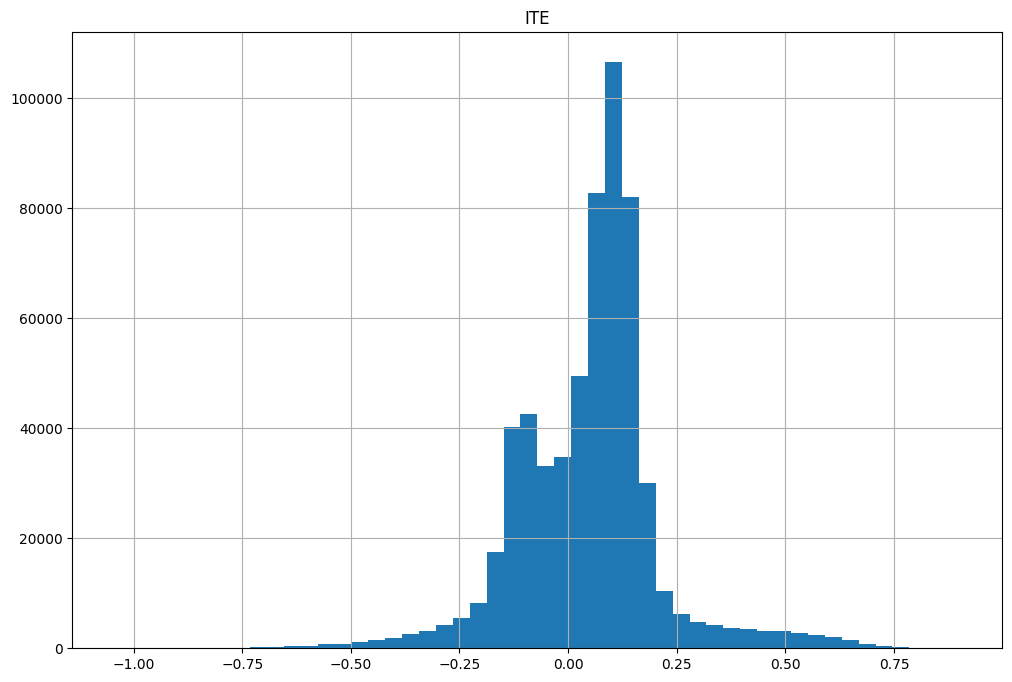

In [50]:
# visualization
ite_df.hist(column ='ITE', 
            bins=50, 
            grid=True, 
            figsize=(12, 8))

__Average Treatment effect__

In [51]:
# Calculate ATE
ite_df.ITE.mean()

0.049204325471511164

# SECTION 4: X Learner Model

## 11. How the X Learner Works?

The X-Learner model uses a more complex approach to model the uplift. It consists of 3 stages:

1. __Stage 1:__ Same as the T-learner. It builds two machine learning models to predict the target.

We create imputed ITE scores where:

- For samples that received treatment, the imputed ITE is actual (typically 1) minus the control model prediction from stage one.
- For the samples that did not receive treatment, the imputed ITE is the treated model prediction from stage one minus the actual (typically 0).

2. __Stage 2:__ Build two machine learning models to predict the imputed ITE, one model is trained using the treated data, and the other model is trained using the control data.

After the stage two models are completed, the imputed ITE predictions will be calculated separately using the treated and the control model for all the samples.

3. __Stage 3:__ Builds a propensity model to predict the probability of getting treated. The predicted propensity score is used as the weight for the individual treatment effect (ITE) calculation. Finally, the ITE is estimated using weighted average of the stage two model predictions, using the propensity scores as the weights.

## 12. Build Stage 1 model: Treatment and control

In [121]:
# Data processing
import pandas as pd
import numpy as np
import seaborn as sns

# Machine learning model
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier

__Import the data__

In [122]:
# pip install scikit-uplift
from sklift.datasets import fetch_megafon
dataset = fetch_megafon()

In [123]:
data, target, treatment = dataset.data, dataset.target, dataset.treatment

In [124]:
target.value_counts()

0    477486
1    122514
Name: conversion, dtype: int64

In [125]:
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858


Assign the target and treament to main dataset.

In [126]:
data['treatment_type'] = treatment
data['target'] = target
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_type,target
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,control,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,control,0
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,treatment,0
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,treatment,0
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,treatment,0


In [127]:
print(data.columns.values.tolist())

['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18', 'X_19', 'X_20', 'X_21', 'X_22', 'X_23', 'X_24', 'X_25', 'X_26', 'X_27', 'X_28', 'X_29', 'X_30', 'X_31', 'X_32', 'X_33', 'X_34', 'X_35', 'X_36', 'X_37', 'X_38', 'X_39', 'X_40', 'X_41', 'X_42', 'X_43', 'X_44', 'X_45', 'X_46', 'X_47', 'X_48', 'X_49', 'X_50', 'treatment_type', 'target']


__Create the X and y data__

In [128]:
# Features
features = data.drop(['target'], axis=1)
features['treatment_type'] = features['treatment_type'].map({"treatment":1, "control":0})

# Treatment Type
treatment = data['treatment_type']

# Dependent variable
y = data.loc[:, ['target']]

In [129]:
features.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_type
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,1
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,1
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,1


__Create separate data for treated and control__

In [130]:
features_treated = features.loc[features.treatment_type==1, :].drop('treatment_type', axis=1)
features_control = features.loc[features.treatment_type==0, :].drop('treatment_type', axis=1)

y_treated = y[features.treatment_type==1]
y_control = y[features.treatment_type==0]

__Train separate models__

The features data contains ONLY the features.

In [131]:
features_treated.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858
7,32.502028,-2.648755,26.614177,-75.283178,-67.063653,-41.213793,-22.906072,-73.475554,57.509013,-173.327229,...,7.777794,56.371228,-185.165228,0.756269,24.365172,0.869576,-520.548609,35.522135,-122.211739,0.721851
8,-111.795983,-0.635505,-34.276797,13.895413,-119.763550,6.611905,37.784961,-83.922006,-7.523688,-27.263564,...,-161.228794,312.424284,-613.366074,-0.603234,88.105256,-1.337192,-694.597882,158.480795,-321.547540,-5.241816


In [132]:
# Light GBM model for the treated
x1_treated = LGBMRegressor().fit(features_treated, y_treated)

# Light GBM model for the control
x1_control = LGBMRegressor().fit(features_control, y_control)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 300368, number of used features: 50
[LightGBM] [Info] Start training from score 0.228919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 299632, number of used features: 50
[LightGBM] [Info] Start training from score 0.179400


__Create predictions__

In [133]:
print(features_control.shape)
print(features_treated.shape)

(299632, 50)
(300368, 50)


In [134]:
# Predict on the control group using the treated model
x_treated_predict = x1_treated.predict(features_control)

# Predict on the treated group using the control model
x_control_predict = x1_control.predict(features_treated)

In [135]:
print(x_treated_predict[:5], "\n", x_control_predict[:5])

[-0.00608098  0.23772862  0.23460161  0.1921504   0.09940783] 
 [0.20743013 0.11544261 0.10020849 0.13343276 0.06656955]


__Create predicted columns__

In [136]:
# Create a column for the predicted outcomes
y_treated['predicted_outcome'] = x_control_predict

# Create a column for the imputed ite
y_treated['imputed_ite'] =  y_treated.apply(lambda row: row.target - row.predicted_outcome, 
                                            axis = 1)

# Create a column for the predicted outcomes
y_control['predicted_outcome'] = x_treated_predict

# Create a column for the imputed ite
y_control['imputed_ite'] =  y_control.apply(lambda row: row.predicted_outcome - row.target, 
                                            axis = 1)

C:\Users\Akash\AppData\Local\Temp\ipykernel_24124\2617433001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_treated['predicted_outcome'] = x_control_predict
C:\Users\Akash\AppData\Local\Temp\ipykernel_24124\2617433001.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_treated['imputed_ite'] =  y_treated.apply(lambda row: row.target - row.predicted_outcome,
C:\Users\Akash\AppData\Local\Temp\ipykernel_24124\2617433001.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

## 13. Build Stage 2 model: Predict imputed uplift

Try to predict the imputed uplift (imputed ITE).

In [138]:
# Treated Model
x2_treated = LGBMRegressor().fit(features_treated, y_treated['imputed_ite'])

# Control model
x2_control = LGBMRegressor().fit(features_control, y_control['imputed_ite'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 300368, number of used features: 50
[LightGBM] [Info] Start training from score 0.048940
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 299632, number of used features: 50
[LightGBM] [Info] Start training from score 0.049469


__2nd Stage Predictions__

Make predictions on all the observations in the data.

In [145]:
# Predictions using the treated model
x2_treated_predict = x2_treated.predict(features.drop('treatment_type', axis=1))

# Save the prediction results as a colum in the dataframe
data['x2_treated_uplift'] = x2_treated_predict

# Predictions using the control model
x2_control_predict = x2_control.predict(features.drop('treatment_type', axis=1))

# Save the prediction results as a colum in the dataframe
data['x2_control_uplift'] = x2_control_predict

## 14. Build Stage 3 Model: Predict Propensity score

Build model to predict the probability of getting treated. We will use the predicted probabilities as weights.


In [146]:
from xgboost import XGBClassifier

In [150]:
features.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_type
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,1
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,1
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,1


The treatment_type is stored as text. Let's map it to numeric.

In [151]:
# Train the XGBoost model
xgb = XGBClassifier(seed=42).fit(features.drop('treatment_type', axis=1), features['treatment_type'])

# Make predictions
xgb_predict_prob = xgb.predict_proba(features.drop('treatment_type', axis=1))[:,1]

# Save the prediction results as a colum in the dataframe
data['treatment_propensity_score'] = xgb_predict_prob

In [152]:
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_48,X_49,X_50,treatment_type,target,x2_treated_predict,x2_control_predict,x2_treated_uplift,x2_control_uplift,treatment_propensity_score
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,44.798182,-125.682413,16.231365,control,0,-0.160059,-0.119701,-0.160059,-0.119701,0.521854
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,-127.737977,-117.501171,10.732234,control,0,0.063038,0.104174,0.063038,0.104174,0.438616
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,-91.009397,-18.173358,14.367636,treatment,0,0.033323,0.079238,0.033323,0.079238,0.494242
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,-22.298302,-75.916603,11.634299,treatment,0,0.104371,0.114840,0.104371,0.114840,0.492315
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,122.019189,194.091195,-11.883858,treatment,0,0.126364,0.115110,0.126364,0.115110,0.528268


__Finally, let's calculate the weighted uplift__

In [153]:
# Weighted ITE
data['Weighted_ITE'] = data.apply(lambda row: (row.treatment_propensity_score * row.x2_control_uplift) + ((1 - row.treatment_propensity_score)*row.x2_treated_uplift), 
                       axis=1)

# View
data.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_49,X_50,treatment_type,target,x2_treated_predict,x2_control_predict,x2_treated_uplift,x2_control_uplift,treatment_propensity_score,Weighted_ITE
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,-125.682413,16.231365,control,0,-0.160059,-0.119701,-0.160059,-0.119701,0.521854,-0.138998
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,-117.501171,10.732234,control,0,0.063038,0.104174,0.063038,0.104174,0.438616,0.081081
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,-18.173358,14.367636,treatment,0,0.033323,0.079238,0.033323,0.079238,0.494242,0.056016
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,-75.916603,11.634299,treatment,0,0.104371,0.114840,0.104371,0.114840,0.492315,0.109525
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,194.091195,-11.883858,treatment,0,0.126364,0.115110,0.126364,0.115110,0.528268,0.120419


## 15. More Resources for advanced modeling

1. Causal ML package [examples](https://causalml.readthedocs.io/en/latest/examples.html)
2. Methods of [scikit-uplift](https://www.uplift-modeling.com/en/v0.3.1/user_guide/index.html)
3. [Evaluating Uplift models](https://towardsdatascience.com/evaluating-uplift-models-8a078996a113) by Matteo Courthourd
4. More methods of [EconML](https://econml.azurewebsites.net/spec/estimation/metalearners.html#t-learner)